# ENSANUT Analysis

This proyect aims to study the correlation (if any) between depression and heart conditions or high blood pressure.

This analysis will use public data provided by ENSANUT polls in Mexico.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

## Data preparation:

### General DataFrame to be used

In [ ]:
path = 'D:/Documentos/UDLAP/Materias/Minería de Datos/Lab3/' # Change the path according to file location
datos = pd.read_csv(path + "ensadul2022_entrega_w.csv", dtype = {0: str}, delimiter = ";", na_values = " ", skiprows = 0, low_memory = False)
cat = pd.read_excel(
    path + "ensadul2022_entrega_w.Catlogo.xlsx", header = [0, 1], sheet_name = 'Variables', index_col = None, skiprows = 15
)
datos_depresion = datos.loc[:, ["a0202", "a0211", "a0212", "a0213", "a0214", "a0215", "a0216", "a0217"]]#   #
datos_hipertension = datos.loc[:, ["a0401", "a0402a", "a0402m", "a0404", "a0404a", "a0405a", "a0405m", "a0406", "a0406a", "a0406b", "a0407", "a0407esp", "A0408A", "A0408E", "a0410ev", "a0410fd", "a0410fv"]]
datos_enfermedad_cardiaca = datos.loc[:, ["a0502a", "a0502b", "a0502c", "a0502d"]]

### DataFrame which will be used for the missing data imputation.

In [ ]:
# First, since we're using the subset of people with high blood pressure,
# we'll remove those entries who answered that they don't have high blood pressure

dfh = datos_hipertension[datos_hipertension["a0401"] != 3].copy()

# We'll define as "missing" an entry which does not know when they were diagnosed
# or if they don't answer anything at all.

dfc = dfh.loc[:, "a0402m"]
dfc = dfc.where(dfc != 88)
dfc = dfc.where(dfc != 99)

dfh["a0402m"] = dfc

dfc = dfh.loc[:, "a0402a"]
dfc = dfc.where(dfc != 88)
dfc = dfc.where(dfc != 99)

dfh["a0402a"] = dfc

# We estimate the invalid values as the median of the column

dfh["a0402m"] = dfh["a0402m"].replace(np.nan, dfh["a0402m"].median())
dfh["a0405a"] = dfh["a0405a"].replace(np.nan, dfh["a0405a"].median())
dfh["a0406b"] = dfh["a0406b"].replace(np.nan, dfh["a0406b"].median())
dfh["a0410ev"] = dfh["a0410ev"].replace(np.nan, dfh["a0410ev"].median())
dfh["a0410fd"] = dfh["a0410fd"].replace(np.nan, dfh["a0410fd"].median())
dfh["a0410fv"] = dfh["a0410fv"].replace(np.nan, dfh["a0410fv"].median())

# We replace the invalid values of column a0406a with their respective 'no' answer
dfh["a0406a"] = dfh["a0406a"].replace(np.nan, 2.0)

# We replace the invalid values of column a0407 with their respective
# 'does not know' answer
dfh["a0407"] = dfh["a0407"].replace(np.nan, 10)

dfh

,a0401,a0402a,a0402m,a0404,a0404a,a0405a,a0405m,a0406,a0406a,a0406b,a0407,a0407esp,A0408A,A0408E,a0410ev,a0410fd,a0410fv
8,1,1.0,7.0,1.0,500.0,7.0,0.0,12.0,2.0,600.0,8.0,NaN,5.0,NaN,1.0,3.0,1.0
10,1,2.0,0.0,1.0,0.0,2.0,0.0,12.0,2.0,0.0,1.0,NaN,5.0,NaN,1.0,3.0,1.0
15,1,30.0,0.0,1.0,0.0,30.0,0.0,2.0,1.0,0.0,1.0,NaN,5.0,NaN,1.0,3.0,1.0
17,1,8.0,0.0,1.0,0.0,8.0,0.0,0.0,2.0,0.0,10.0,NaN,5.0,NaN,1.0,3.0,1.0
33,1,9.0,0.0,1.0,0.0,9.0,0.0,8.0,2.0,0.0,1.0,NaN,5.0,NaN,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11902,1,7.0,0.0,1.0,0.0,7.0,0.0,12.0,2.0,0.0,2.0,NaN,5.0,NaN,1.0,3.0,1.0
11904,1,2.0,0.0,1.0,300.0,2.0,0.0,3.0,2.0,300.0,8.0,NaN,5.0,NaN,1.0,3.0,1.0
11905,1,2.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,10.0,NaN,5.0,NaN,1.0,3.0,1.0
11906,1,4.0,0.0,1.0,0.0,4.0,0.0,12.0,2.0,0.0,4.0,NaN,5.0,NaN,1.0,3.0,1.0


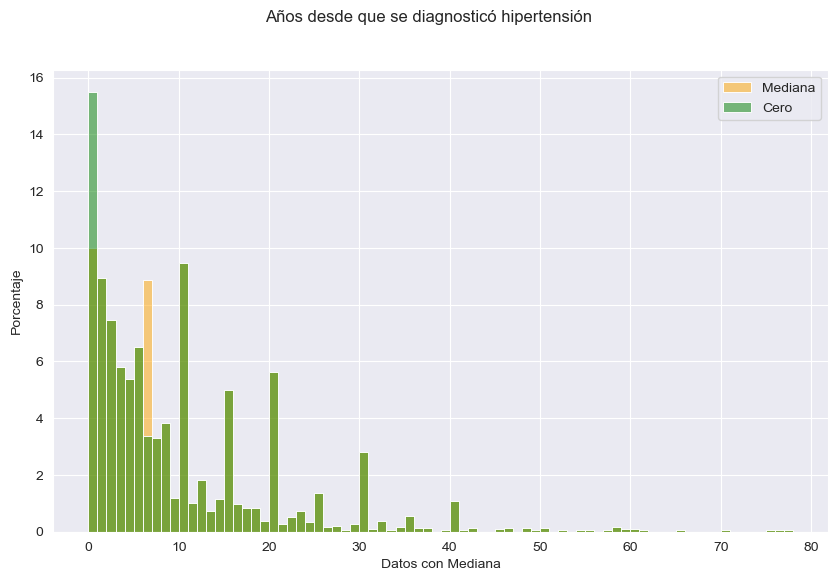

,Datos a Cero,a0401
8,1.0,1
10,2.0,1
15,30.0,1
17,8.0,1
33,9.0,1
...,...,...
11902,7.0,1
11904,2.0,1
11905,2.0,1
11906,4.0,1


In [ ]:
# We graph the years since each individual was diagnosed to compare the normal
# data with the estimate data

# df_im: DataFrame with imputated data
# df_un: DataFrame with untouched data

med = dfh["a0402a"].median()
# dfh = dfh[dfh["a0402a"] <= 10]

df_im = dfh.loc[:, ["a0402a", "a0401"]]
df_im["a0402a"] = dfh["a0402a"].replace(np.nan, med)

df_im.rename(columns = {"a0402a": "Datos con Mediana"}, inplace = True)

df_un = dfh.loc[:, ["a0402a", "a0401"]]
df_un["a0402a"] = dfh["a0402a"].replace(np.nan, 0)
df_un.rename(columns = {"a0402a": "Datos a Cero"}, inplace = True)

# Create figure and axes

fig, ax = plt.subplots(figsize = (10, 6))

sns.histplot(
    data = df_im.loc[:, "Datos con Mediana"],
    binwidth = 1,
    color = "orange",
    alpha = 0.5,
    stat = "percent",
    label = "Mediana"
)

sns.histplot(
    data = df_un.loc[:, "Datos a Cero"],
    binwidth = 1,
    color = "green",
    alpha = 0.5,
    stat = "percent",
    label = "Cero"
)



# Set up style and title

fig.suptitle("Años desde que se diagnosticó hipertensión")
ax.set_ylabel("Porcentaje")
plt.legend()

plt.show()

df_un

In [ ]:
datos_hipertension.replace(np.nan, 0, inplace = True)
datos_hipertension = datos_hipertension[datos["a0406"] < 99]
max1 = datos_hipertension["a0406"].max()

# We apply MaxAbs on the column

datos_hipertension["a0406"] = datos_hipertension["a0406"] / max1

# Second, we obtain the maximum value of column 'a0401ev'
# This column does not contain special options

max2 = datos_hipertension["a0410ev"].max()

# We apply MaxAbs on the column

datos_hipertension["a0410ev"] = datos_hipertension["a0410ev"] / max2

# We calculate the "Score" as a lineal combination

datos_hipertension["Hip_Score"] = datos_hipertension["a0404"] + datos_hipertension["a0406"] + 2 * datos_hipertension["a0410ev"]

# We convert to percentage dividing over the maximum value

datos_hipertension["Hip_Score"] = datos_hipertension["Hip_Score"] / 4

## Functions to generate graphs.

---



In [ ]:
# Obtener la pregunta a partir de la etiqueta de la columna

def get_title(fl_cat, label):
  # Filtramos datos para obtener el nombre de la columna, convirtiendo la celda de la tupla
  # en un numpy.array, y obtenemos el valor que nos interesa
  fl_cat_filt = fl_cat[fl_cat['Información de variable']['Variable'] == label]
  title = fl_cat_filt[('Información de variable', 'Etiqueta')].to_numpy()[0]
  return title

In [ ]:
# Obtener la grafica de correlacion de una lista de columnas de una tabla

def graph_correlation(dataframe, column_list, label_list, title):
    dataframe = dataframe.loc[:, column_list]

    correlation_matrix = dataframe.corr()

    ax = sns.heatmap(
        correlation_matrix,
        cmap = "BrBG",
        vmin = -1,
        vmax = 1,
        annot = True,
        linewidth = 1,
        xticklabels = label_list,
        yticklabels = label_list,
        square = True
    )

    ax.set_title(title)

## Data transformations

---



### Generalizing a score based on depressive symptomalotogy.

In [ ]:
# Calculo del "Score" de Depresion

# Obtenemos la lista de columnas que se usaran para calcular dicho "Score"

dlst = ["a0212", "a0213", "a0214", "a0215", "a0216", "a0217"]

# Ajustamos la columna a0216 para darle mas peso a las respuestas mas negativas
# Puesto que en esta columna, las respuestas mayores son positivas

datos_depresion["a0216"] =  5 - datos_depresion["a0216"]

# Ajustamos la respuesta para que vaya de 0 a 3

for column in dlst:
    datos_depresion[column] = datos_depresion[column] - 1

# Calculamos el "Score" como una suma (transformacion lineal) de las respuestas

datos_depresion["Dep_Score"] = datos_depresion[dlst].sum(axis = 1)

# Realizamos una conversion a % dividiendo sobre el maximo

datos_depresion["Dep_Score"] = datos_depresion["Dep_Score"] / 18

datos_depresion

,a0202,a0211,a0212,a0213,a0214,a0215,a0216,a0217,Dep_Score
0,1,1,1,1,2,1,0,1,0.333333
1,2,1,0,0,0,0,0,0,0.000000
2,2,1,0,0,1,0,0,0,0.055556
3,1,1,0,0,0,0,0,0,0.000000
4,2,1,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...
11908,2,2,0,2,2,2,3,2,0.611111
11909,2,1,0,0,0,0,0,0,0.000000
11910,2,1,0,0,0,0,0,0,0.000000
11911,2,1,0,0,0,0,0,0,0.000000


### Generalizing a score based on high blood pressure syntomatology


In [ ]:
datos_hipertension.replace(np.nan, 0)

,a0401,a0402a,a0402m,a0404,a0404a,a0405a,a0405m,a0406,a0406a,a0406b,a0407,a0407esp,A0408A,A0408E,a0410ev,a0410fd,a0410fv,Hip_Score
8,1,1.0,7.0,1.0,500.0,7.0,0.0,0.292683,2.0,600.0,8.0,0,5.0,0.0,0.0,0.0,0.0,0.323171
10,1,2.0,0.0,1.0,0.0,2.0,0.0,0.292683,2.0,0.0,1.0,0,5.0,0.0,0.0,0.0,0.0,0.323171
15,1,30.0,0.0,1.0,0.0,30.0,0.0,0.048780,1.0,0.0,1.0,0,5.0,0.0,0.0,0.0,0.0,0.262195
17,1,8.0,0.0,1.0,0.0,8.0,0.0,0.000000,0.0,0.0,0.0,0,5.0,0.0,0.0,0.0,0.0,0.250000
33,1,9.0,0.0,1.0,0.0,9.0,0.0,0.195122,2.0,0.0,1.0,0,5.0,0.0,0.0,0.0,0.0,0.298780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11902,1,7.0,0.0,1.0,0.0,7.0,0.0,0.292683,2.0,0.0,2.0,0,5.0,0.0,0.0,0.0,0.0,0.323171
11904,1,2.0,0.0,1.0,300.0,2.0,0.0,0.073171,2.0,300.0,8.0,0,5.0,0.0,0.0,0.0,0.0,0.268293
11905,1,2.0,0.0,1.0,0.0,2.0,0.0,0.000000,0.0,0.0,0.0,0,5.0,0.0,0.0,0.0,0.0,0.250000
11906,1,4.0,0.0,1.0,0.0,4.0,0.0,0.292683,2.0,0.0,4.0,0,5.0,0.0,0.0,0.0,0.0,0.323171


In [ ]:
# Calculo del "Score" de Hipertension

# Calculamos el "Score" como una suma (transformacion lineal) de las respuestas
# 'a0404' + 'a0406' (MaxAbs) + 2 * 'a0410ev' (MaxAbs)

# Primero, obtenemos el maximo de la columna 'a0406'
# Dado que existe la respuesta 99 como opcion especial, procedemos a quitarla
# antes de realizar la transformacion

datos_hipertension.replace(np.nan, 0, inplace = True)
datos_hipertension = datos_hipertension[datos["a0406"] < 99]
max1 = datos_hipertension["a0406"].max()

# Aplicamos el MaxAbs sobre la columna

datos_hipertension["a0406"] = datos_hipertension["a0406"] / max1

# Segundo, obtenemos el maximo de la columna 'a0410ev'
# Esta columna NO tiene opciones especiales

max2 = datos_hipertension["a0410ev"].max()

# Aplicamos el MaxAbs sobre la columna

datos_hipertension["a0410ev"] = datos_hipertension["a0410ev"] / max2

# Calculamos el "Score" como la combinacion lineal mencionada

datos_hipertension["Hip_Score"] = datos_hipertension["a0404"] + datos_hipertension["a0406"] + 2 * datos_hipertension["a0410ev"]

# Realizamos una conversion a % dividiendo sobre el maximo

datos_hipertension["Hip_Score"] = datos_hipertension["Hip_Score"] / 4

datos_hipertension

C:\Users\tiago\AppData\Local\Temp\ipykernel_24588\2586225781.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  datos_hipertension = datos_hipertension[datos["a0406"] < 99]


,a0401,a0402a,a0402m,a0404,a0404a,a0405a,a0405m,a0406,a0406a,a0406b,a0407,a0407esp,A0408A,A0408E,a0410ev,a0410fd,a0410fv,Hip_Score
8,1,1.0,7.0,1.0,500.0,7.0,0.0,0.292683,2.0,600.0,8.0,0,5.0,0.0,0.0,0.0,0.0,0.323171
10,1,2.0,0.0,1.0,0.0,2.0,0.0,0.292683,2.0,0.0,1.0,0,5.0,0.0,0.0,0.0,0.0,0.323171
15,1,30.0,0.0,1.0,0.0,30.0,0.0,0.048780,1.0,0.0,1.0,0,5.0,0.0,0.0,0.0,0.0,0.262195
17,1,8.0,0.0,1.0,0.0,8.0,0.0,0.000000,0.0,0.0,0.0,0,5.0,0.0,0.0,0.0,0.0,0.250000
33,1,9.0,0.0,1.0,0.0,9.0,0.0,0.195122,2.0,0.0,1.0,0,5.0,0.0,0.0,0.0,0.0,0.298780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11902,1,7.0,0.0,1.0,0.0,7.0,0.0,0.292683,2.0,0.0,2.0,0,5.0,0.0,0.0,0.0,0.0,0.323171
11904,1,2.0,0.0,1.0,300.0,2.0,0.0,0.073171,2.0,300.0,8.0,0,5.0,0.0,0.0,0.0,0.0,0.268293
11905,1,2.0,0.0,1.0,0.0,2.0,0.0,0.000000,0.0,0.0,0.0,0,5.0,0.0,0.0,0.0,0.0,0.250000
11906,1,4.0,0.0,1.0,0.0,4.0,0.0,0.292683,2.0,0.0,4.0,0,5.0,0.0,0.0,0.0,0.0,0.323171


### Generalizing a score based on heart condition symptomatology.

---



In [ ]:
# Calculamos el "Score" de enfermedades Cardiacas

# Calculamos el "Score" como una transformación lineal de las respuestas:
# 5 * "a0502a" + "a0502b" + 3 * "a0502c" + 4 "a0502d"

clst = ["a0502a", "a0502b", "a0502c", "a0502d"]

for column in clst:
    datos_enfermedad_cardiaca[column] = 2 - datos_enfermedad_cardiaca[column]

# Calculamos el "Score" como la combinacion lineal mencionada

datos_enfermedad_cardiaca["Car_Score"] = 5 * datos_enfermedad_cardiaca["a0502a"] + datos_enfermedad_cardiaca["a0502b"] + 3 * datos_enfermedad_cardiaca["a0502c"] + 4 * datos_enfermedad_cardiaca["a0502d"]

# Realizamos una conversion a % dividiendo sobre el maximo

datos_enfermedad_cardiaca["Car_Score"] = datos_enfermedad_cardiaca["Car_Score"] / 13

datos_enfermedad_cardiaca

,a0502a,a0502b,a0502c,a0502d,Car_Score
0,0,0,0,0,0.0
1,0,0,0,0,0.0
2,0,0,0,0,0.0
3,0,0,0,0,0.0
4,0,0,0,0,0.0
...,...,...,...,...,...
11908,0,0,0,0,0.0
11909,0,0,0,0,0.0
11910,0,0,0,0,0.0
11911,0,0,0,0,0.0


## Chi-squared Test


Data to relate:
  - Depression diagnosis (a0202) with:
    - Heart attack diagnosis (a0502a)
    - Angina pectoris diagnodis (a0502b)
    - Cardiac insuficiency diagnosis (a0502c)
    - Embolism diagnosis (a0205d)
    - High blood pressure diagnosis (a0401)


Previo a las pruebas, necesitamos limpiar una de las variables para reducirle una dimension:
Prior to testing, we'll need to clean one of the variables to reduce one dimension.

In [ ]:
datos_hipertension["Hip_Score"].unique()

array([0.32317073, 0.26219512, 0.25      , 0.29878049, 0.52439024,
       0.2804878 , 0.26829268, 0.25609756, 0.32439024, 0.28658537,
       0.47317073, 0.30487805, 0.51219512, 0.31707317, 0.27439024,
       0.62195122, 0.41219512, 0.42439024, 0.57317073, 0.43658537,
       0.5       , 0.39146341, 0.50609756, 0.31097561, 0.36707317,
       0.35      , 0.42317073, 0.3304878 , 0.30609756, 0.37317073,
       0.41707317, 0.57317073, 0.33658537, 0.45487805, 0.51829268,
       0.31829268, 0.56829268, 0.31219512, 0.65      , 0.3       ,
       0.55      , 0.55487805, 0.51707317, 0.29268293, 0.34268293,
       0.46829268, 0.54268293, 0.68658537, 0.46097561, 0.44512195,
       0.55609756, 0.34146341, 0.38658537, 0.54878049, 0.53658537,
       0.36829268, 0.6195122 , 0.41829268, 0.36219512, 0.36097561,
       0.5804878 , 0.37439024, 0.39634146, 0.37195122, 0.3597561 ,
       0.5304878 , 0.4       , 0.33536585, 0.62317073, 0.41097561,
       0.56707317, 0.35487805, 0.56097561, 0.34878049, 0.81097

This is the high blood pressure diagnosis variable, in the questionaire, there are three possible answers "yes", "yes during pregnancy", "no". To reduce one dimension, we'll add the "yes" and "yes during pregnancy" together, since its not normal for pregnant women to have high blood pressure constantly.

In [ ]:
datos_hipertension["a0401"] = datos_hipertension["a0401"].mask(datos_hipertension["a0401"] == 2, 1)

We can now proceed with the rest of the test...

In [ ]:
# Funcion para tabla de contingencia
def contingencia(col1, col2):
  tab = pd.crosstab(col1, col2)
  return tab

Test one: Depression diagnosis with heart attack diagnosis

In [ ]:
# Prueba 1: depresion con ataque al corazon
tabla_prueba_1 = contingencia(datos_depresion["a0202"], datos_enfermedad_cardiaca["a0502a"])

estadistico_prueba_1, p_prueba_1, dof_prueba_1, expected_prueba_1 = chi2_contingency(tabla_prueba_1)
print(estadistico_prueba_1)
print(p_prueba_1)
print(dof_prueba_1)
print(expected_prueba_1)

19.551400689211757
9.792890933523373e-06
1
[[ 1412.70729455    29.29270545]
 [10258.29270545   212.70729455]]


Test two: Depression diagnosis with angina pectoris diagnosis

In [ ]:
# Prueba 2: depresion con angina de pecho
tabla_prueba_2 = contingencia(datos_depresion["a0202"], datos_enfermedad_cardiaca["a0502b"])

estadistico_prueba_2, p_prueba_2, dof_prueba_2, expected_prueba_2 = chi2_contingency(tabla_prueba_2)
print(estadistico_prueba_2)
print(p_prueba_2)
print(dof_prueba_2)
print(expected_prueba_2)

10.030386114484928
0.0015397875641828505
1
[[ 1415.61235625    26.38764375]
 [10279.38764375   191.61235625]]


Test three: Depression diagnosis with cardiac insuficiency diagnosis

In [ ]:
# Prueba 3: depresion con insuficiencia cardiaca
tabla_prueba_3 = contingencia(datos_depresion["a0202"], datos_enfermedad_cardiaca["a0502c"])

estadistico_prueba_3, p_prueba_3, dof_prueba_3, expected_prueba_3 = chi2_contingency(tabla_prueba_3)
print(estadistico_prueba_3)
print(p_prueba_3)
print(dof_prueba_3)
print(expected_prueba_3)

48.726192231195526
2.9430958408617285e-12
1
[[ 1415.73340049    26.26659951]
 [10280.26659951   190.73340049]]


Test four: Depression diagnosis with embolism diagnosis

In [ ]:
# Prueba 4: depresion con embolia
tabla_prueba_4 = contingencia(datos_depresion["a0202"], datos_enfermedad_cardiaca["a0502d"])

estadistico_prueba_4, p_prueba_4, dof_prueba_4, expected_prueba_4 = chi2_contingency(tabla_prueba_4)
print(estadistico_prueba_4)
print(p_prueba_4)
print(dof_prueba_4)
print(expected_prueba_4)

3.491985736612559
0.0616665736275292
1
[[ 1426.38529338    15.61470662]
 [10357.61470662   113.38529338]]


Test five: Depression diagnosis with high blood pressure diagnosis

In [ ]:
# Prueba 5: depresion con hipertension
tabla_prueba_5 = contingencia(datos_depresion["a0202"], datos["a0401"])

estadistico_prueba_5, p_prueba_5, dof_prueba_5, expected_prueba_5 = chi2_contingency(tabla_prueba_5)

print(estadistico_prueba_5)
print(p_prueba_5)
print(dof_prueba_5)
print(expected_prueba_5)

189.19110000944534
8.273220898826382e-42
2
[[2.73681021e+02 3.51028288e+00 1.16480870e+03]
 [1.98731898e+03 2.54897171e+01 8.45819130e+03]]


In [ ]:
datos['a0401'].unique()

array([3, 1, 2], dtype=int64)

## Visualization

### Score comparisons (BoxPlot)

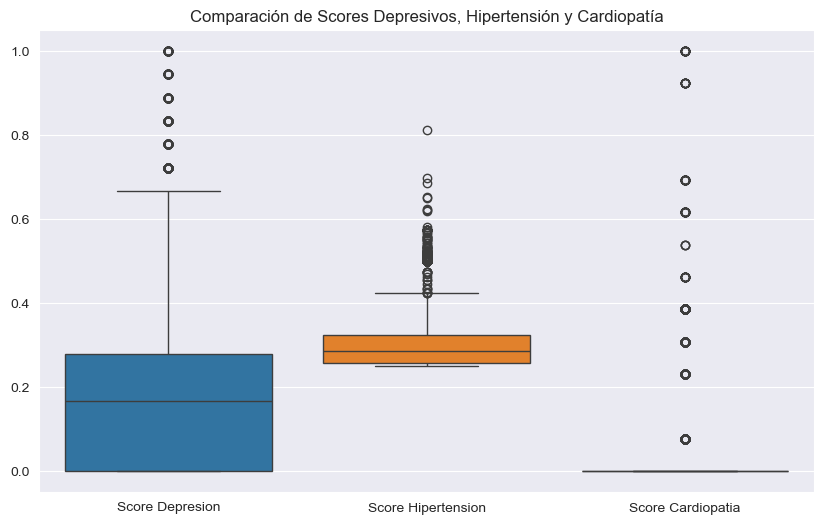

In [ ]:
# Asumimos que tienes dos DataFrames: datos_depresion y datos_hipertension
# Si no es así, ajusta el código según tus datos reales
# De aqui, creamos un nuevo DataFrame que una ambas columnas

merge_list = [
    datos_depresion.loc[:, "Dep_Score"],
    datos_hipertension.loc[:, "Hip_Score"],
    datos_enfermedad_cardiaca.loc[:, "Car_Score"]
]

datos_scores = pd.concat(merge_list, axis = 1)

# Dado que el BoxPlot de SeaBorn no permite configurar las etiquetas por separado,
# cambiamos el nombre directamente por medio de un renombrado de las columnas

new_columns = {"Dep_Score": "Score Depresion", "Hip_Score": "Score Hipertension", "Car_Score": "Score Cardiopatia"}

datos_scores.rename(columns = new_columns, inplace = True)

# Crear la figura y los ejes

fig, ax = plt.subplots(figsize = (10, 6))

# Crear el boxplot

data_list = [
    datos_scores.loc[:, "Score Depresion"],
    datos_scores.loc[:, "Score Hipertension"],
    datos_scores.loc[:, "Score Cardiopatia"]
]

sns.boxplot(data = data_list, ax = ax)

# Configurar el estilo y título

sns.set_style("darkgrid")
ax.set_title("Comparación de Scores Depresivos, Hipertensión y Cardiopatía")

# Mostrar la gráfica

plt.show()

### Heart condition frequency visualization.

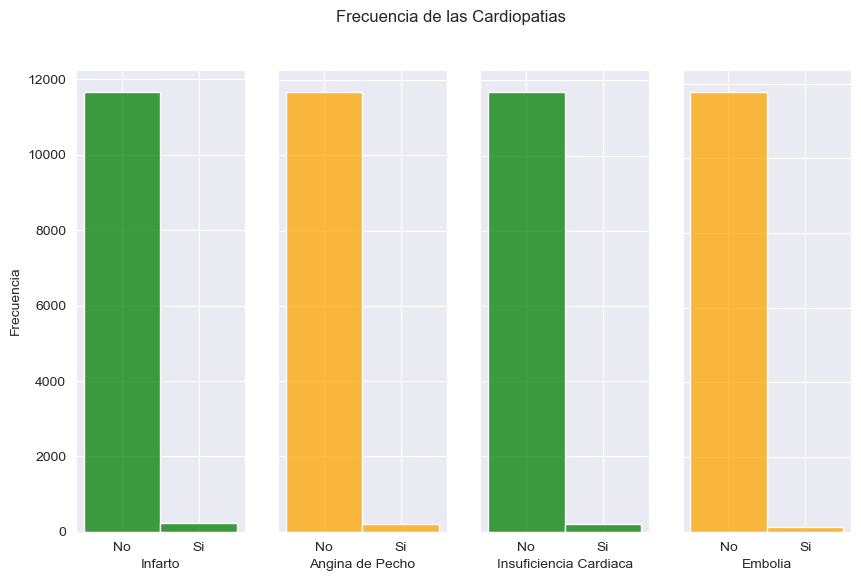

In [ ]:
# Graficamos los datos de Cardiopatias por separado con tal de evidenciar
# los problemas que existen en los datos
# Para ello, copiamos el dataframe y renombramos las columnas, de manera que puedan ser
# entendiddas de mejor manera en la grafica

df = datos_enfermedad_cardiaca.loc[:, ["a0502a", "a0502b", "a0502c", "a0502d"]]
df = df.mask(df == 1, "Si")
df = df.mask(df == 0, "No")

new_columns = {
    "a0502a": "Infarto",
    "a0502b": "Angina de Pecho",
    "a0502c": "Insuficiencia Cardiaca",
    "a0502d": "Embolia",
}

df.rename(columns = new_columns, inplace = True)

# Crear la figura y los ejes

fig, ax = plt.subplots(1, 4, figsize = (10, 6))

sns.histplot(ax = ax[0], data = df.loc[:, "Infarto"], binwidth = 0.5, color = "green")
sns.histplot(ax = ax[1], data = df.loc[:, "Angina de Pecho"], binwidth = 0.5, color = "orange")
sns.histplot(ax = ax[2], data = df.loc[:, "Insuficiencia Cardiaca"], binwidth = 0.5, color = "green")
sns.histplot(ax = ax[3], data = df.loc[:, "Embolia"], binwidth = 0.5, color = "orange")

# Eliminar las etiquetas y títulos de los ejes y, dejando unicamente el primero

ax[0].set_ylabel("Frecuencia")

for i in range(1, 4):
    ax[i].set_ylabel("")  # Elimina el título del eje Y
    ax[i].tick_params(axis = "y", labelleft = False)  # Elimina las etiquetas del eje Y

# Configurar el estilo y título

fig.suptitle("Frecuencia de las Cardiopatias")

# Mostrar la gráfica

plt.show()

### Comparison between depressive score and diagnosis

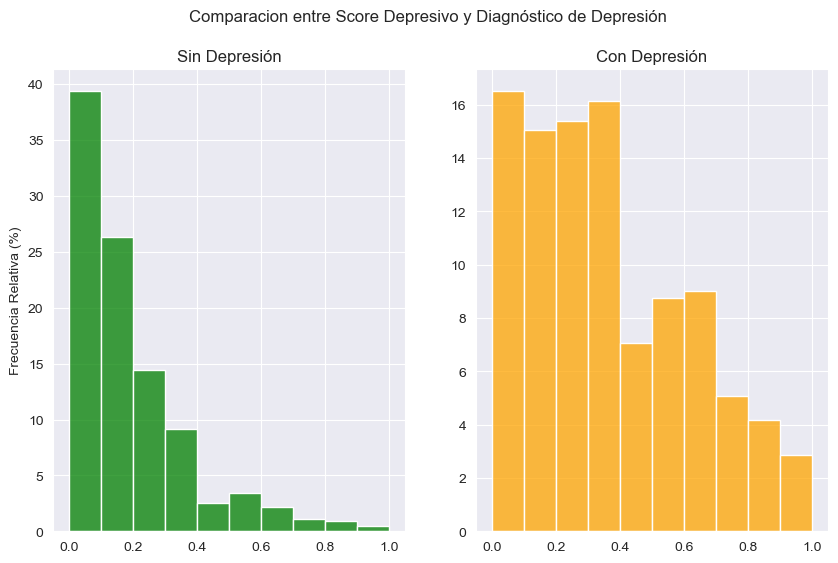

In [ ]:
# Graficamos el Score de Depresion ajustado segun si la persona tiene o no diagnosticada depresion
# df_dp = DataFrame Depresion Positivo
# df_dn = DataFrame Depresion Negativo

df_dp = datos_depresion[datos_depresion["a0202"] == 1]
df_dn = datos_depresion[datos_depresion["a0202"] == 2]

# Crear la figura y los ejes

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
fig.suptitle("Comparacion entre Score Depresivo y Diagnóstico de Depresión")

sns.histplot(ax = ax[0], data = df_dn.loc[:, "Dep_Score"], binwidth = 0.1, color = "green", stat = "percent")
ax[0].set_title("Sin Depresión")
ax[0].set_ylabel("Frecuencia Relativa (%)")
sns.histplot(ax = ax[1], data = df_dp.loc[:, "Dep_Score"], binwidth = 0.1, color = "orange", stat = "percent")
ax[1].set_title("Con Depresión")
ax[1].set_ylabel("")

for ax in ax:
    ax.set_xlabel("")

plt.show()

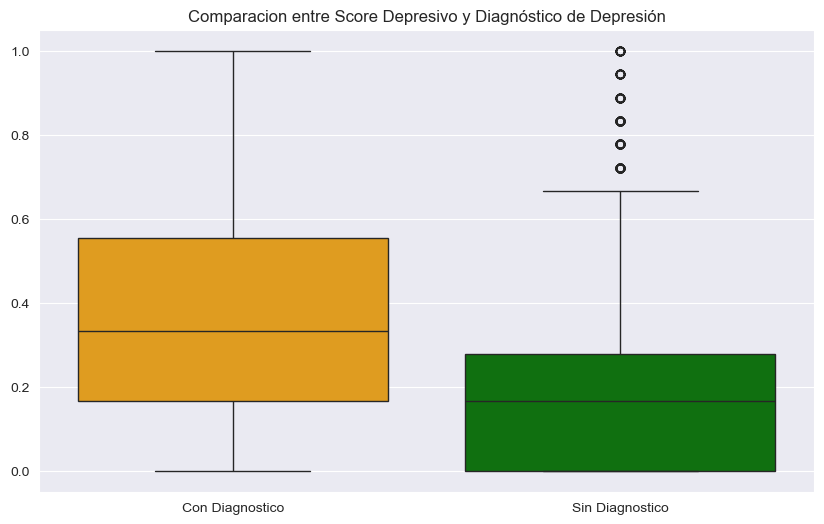

In [ ]:
# Asumimos que tienes dos DataFrames: Score con diagnostico y sin diagnostico
# Si no es así, ajusta el código según tus datos reales
# De aqui, creamos un nuevo DataFrame que una ambas columnas

# Dado que el BoxPlot de SeaBorn no permite configurar las etiquetas por separado,
# cambiamos el nombre directamente por medio de un renombrado de las columnas

dp = df_dp.loc[:, ["Dep_Score", "a0202"]]
dp.rename(columns = {"Dep_Score": "Con Diagnostico"}, inplace = True)

dn = df_dn.loc[:, ["Dep_Score", "a0202"]]
dn.rename(columns = {"Dep_Score": "Sin Diagnostico"}, inplace = True)

# Crear la figura y los ejes

fig, ax = plt.subplots(figsize = (10, 6))

# Crear el boxplot

data_list = [
    dp["Con Diagnostico"],
    dn["Sin Diagnostico"]
]

sns.boxplot(data = data_list, ax = ax, palette = ["orange", "green"])

# Configurar el estilo y título

sns.set_style("darkgrid")
ax.set_title("Comparacion entre Score Depresivo y Diagnóstico de Depresión")

# Mostrar la gráfica

plt.show()

### Correlation between scores

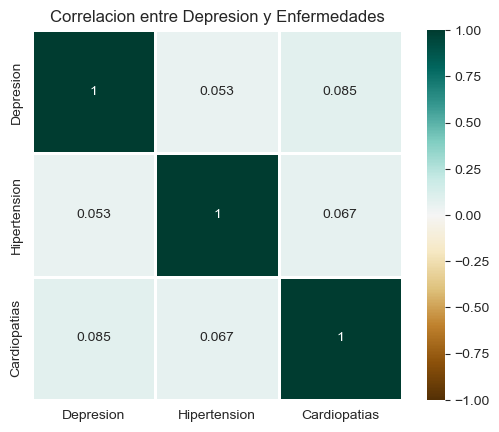

In [ ]:
column_list = ["Score Depresion", "Score Hipertension", "Score Cardiopatia"]
label_list = ["Depresion", "Hipertension", "Cardiopatias"]
title = "Correlacion entre Depresion y Enfermedades"

graph_correlation(datos_scores, column_list, label_list, title)

## Conclusion:

After the previous analysis. We can clearly see that there is no conclusive correlation between depression, high blood pressure and cardiac problems in the given population sample.